<a href="https://colab.research.google.com/github/LucaB999/Market_Basket_Analysis/blob/main/MBA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Environment setup



In [ ]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://dlcdn.apache.org/spark/spark-3.4.0/spark-3.4.0-bin-hadoop3.tgz
!tar xf spark-3.4.0-bin-hadoop3.tgz

In [ ]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.4.0-bin-hadoop3"

In [ ]:
!pip install -q findspark
import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()

In [ ]:
sc = spark.sparkContext

In [ ]:
import pandas as pd
import numpy as np
from itertools import product, combinations

# Import MeDAL dataset

In [ ]:
# Insert your own kaggle keys
os.environ['KAGGLE_USERNAME'] = "xxxxxxxx"
os.environ['KAGGLE_KEY'] = "xxxxxxxx"
!kaggle datasets download -d xhlulu/medal-emnlp --unzip

100% 6.81G/6.82G [01:16<00:00, 79.3MB/s]
100% 6.82G/6.82G [01:16<00:00, 96.2MB/s]


In [ ]:
# Read the dataset
df = spark.read.csv("full_data.csv", header = True, sep=",")

# Preview of the dataset
#df.show()

In [ ]:
# Take a subset
subset = df.sample(False,0.001,seed = 33)

In [ ]:
# Convert the subset to rdd and take only the column 'text'
rdd = subset.rdd.map(lambda x: x[0])

In [ ]:
rdd.take(1)

['clostridium perfringens sialidase was purified by affinity chromatography kinetic properties of the enzyme were examined with sialyllactose and with mixed sialoglycolipids gangliosides as substrates with the latter ATP in m trisacete in the absence of strong electrolyte the ph optimum for enzymatic activity was addition of strong electrolyte to m nac to the reaction medium caused an acidic shift and a broadening of the ph optimum enzymatic activity at ph rose approximately fold a concomitant loss of activity at ph was also observed the alteration of enzymatic activity caused by strong electrolyte were dependent upon changes in vmax km remained nearly invariant thus a reversible transition of the enzyme from a relatively inactive to a highly active form occurred as a CF of strong electrolyte concentration determination of the pk values of the active functional groups of c perfringens sialidase revealed that the effects of strong electrolyte were exerted upon the pka group of the enzym

# Pre-processing Data

In [ ]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import string

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

def preprocess_text(text):
    # Convert text to lowercase
    text = text.lower()

    # Tokenize the text
    tokens = nltk.word_tokenize(text)

    # Remove punctuation
    tokens = [token for token in tokens if token not in string.punctuation]

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]

    # Lemmatize the tokens
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]

    return tokens


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [ ]:
# Apply preprocess_text to the rdd
rdd = rdd.map(preprocess_text)

In [ ]:
rdd.take(1)

[['clostridium',
  'perfringens',
  'sialidase',
  'purified',
  'affinity',
  'chromatography',
  'kinetic',
  'property',
  'enzyme',
  'examined',
  'sialyllactose',
  'mixed',
  'sialoglycolipids',
  'gangliosides',
  'substrate',
  'latter',
  'atp',
  'trisacete',
  'absence',
  'strong',
  'electrolyte',
  'ph',
  'optimum',
  'enzymatic',
  'activity',
  'addition',
  'strong',
  'electrolyte',
  'nac',
  'reaction',
  'medium',
  'caused',
  'acidic',
  'shift',
  'broadening',
  'ph',
  'optimum',
  'enzymatic',
  'activity',
  'ph',
  'rose',
  'approximately',
  'fold',
  'concomitant',
  'loss',
  'activity',
  'ph',
  'also',
  'observed',
  'alteration',
  'enzymatic',
  'activity',
  'caused',
  'strong',
  'electrolyte',
  'dependent',
  'upon',
  'change',
  'vmax',
  'km',
  'remained',
  'nearly',
  'invariant',
  'thus',
  'reversible',
  'transition',
  'enzyme',
  'relatively',
  'inactive',
  'highly',
  'active',
  'form',
  'occurred',
  'cf',
  'strong',
  'e

In [ ]:
def create_vocabulary(rdd):

    # Assign a index to each word
    i2w = rdd.flatMap(lambda line:line)\
                      .distinct().zipWithIndex()\
                      .map(lambda x: (x[1], x[0]))\
                      .collectAsMap()


    # Reverse the key, value pairs
    w2i = {value:key for key, value in i2w.items()}

    return i2w, w2i

In [ ]:
# Create the vocabularies
i2w, w2i = create_vocabulary(rdd)

In [ ]:
# Substitute each word by its corresponding index
def create_indexing(rdd, w2i):
 return rdd.map(lambda sentence: [w2i[word] for word in sentence])

In [ ]:
rdd = create_indexing(rdd, w2i)

# A-priori Algorithm

In [ ]:
#Define the 'new_combinations' function that takes an rdd (items) containing the result of the
#function apriori at step i-1 and the index i which indicates the size of the
#combinations of words (starts from i=3 for triples).
#The function generates the singletons from "items" and evaluate the carthesian product
#between "items" and the singletons.
#Returns the combinations which have size = i removing every possible permutation.

def new_combinations(items, i):
  #removes the counter from each item
  items = items.map(lambda item: list(item[0]))
  #generate singletons from each item in items
  singletons = items.flatMap(list)\
                    .map(lambda item:(item,1))\
                    .reduceByKey(lambda x,y: x+y)\
                    .map(lambda item:item[0])
  #create an empty list that will contain the new possible combinations
  items_set = []
  #for cicle generates the new combinations using the Cartesian product between items and singletons
  for comb in list(product(items.toLocalIterator(), singletons.toLocalIterator())):
    #merges the two lists into a "new item" with form "new item"=[item, singleton]
    comb = comb[0]+comb[1]
    #take the set of each combination and sort it to prevent permutations to
    #be counted as different item and to remove the repetitions of words
    comb_set = sorted(set().union(comb))
    #if the set has size = i and was not already included in items_set
    #then it is added to items_set
    if (len(comb_set) == i) and comb_set not in items_set:
        items_set.append(comb_set)
  return items_set

In [ ]:
#Define the apriori function that takes as parameters an rdd and the minumum support (threshold) to evaluate the frequent pairs, triples etc.
#Returns an rdd (results) containing all the frequent items and their occurrencies

def apriori(rdd, threshold):
  #create 'results' as an empty rdd
  results = sc.parallelize([])

  #generate frequent singletons
  singletons = rdd.flatMap(list)\
                  .map(lambda item: (item,1))\
                  .reduceByKey(lambda x,y: x+y)\
                  .filter(lambda item: item[1] >= threshold)

  #add frequent singletons
  results = results.union(singletons)

  singletons = singletons.map(lambda x: x[0])

  #find the possible pairs
  possible_combinations = list(combinations(singletons.toLocalIterator(),2))

  i=3 #size of candidates

  while len(possible_combinations)>0:

    #check whether the possible items are frequent
    frequent_items = rdd.flatMap(lambda sentence: [(tuple(item), 1) for item in possible_combinations if set(list(item)).issubset(set(sentence))]) \
                    .reduceByKey(lambda x, y: x+y) \
                    .filter(lambda item: item[1] >= threshold)
    #add the frequent items and their occurrencies to results
    results = results.union(frequent_items)

    #generates new items from the last frequent items found using the function defined above
    possible_combinations = new_combinations(frequent_items, i)

    #increment i
    i += 1

  return results

In [ ]:
#compute the threshold (min support) using 0.03 as fraction of the number of baskets
#in order for pairs, triple, ecc. to be considered frequent
count = rdd.count()
threshold = count*0.03
print(count, threshold)

14357 430.71


In [ ]:
results = apriori(rdd, threshold) #run the algorithm

In [ ]:
results = results.collect()

In [ ]:
results

[(35369, 952),
 (53449, 2241),
 (4859, 452),
 (75597, 542),
 (35370, 484),
 (54128, 600),
 (4182, 775),
 (13900, 602),
 (7572, 628),
 (55597, 1448),
 (61812, 1166),
 (74242, 687),
 (30511, 672),
 (18760, 591),
 (4861, 1303),
 (8251, 1095),
 (61813, 2248),
 (26331, 717),
 (61135, 581),
 (43169, 894),
 (18761, 582),
 (53452, 2695),
 (3, 697),
 (54130, 779),
 (4862, 461),
 (7574, 534),
 (64526, 791),
 (61814, 1000),
 (75600, 484),
 (9721, 500),
 (38876, 679),
 (43170, 741),
 (54131, 2360),
 (35373, 1172),
 (11079, 1536),
 (43171, 5148),
 (52776, 458),
 (18763, 1369),
 (48030, 506),
 (11080, 1687),
 (38878, 737),
 (53455, 741),
 (54133, 438),
 (6, 581),
 (53456, 1079),
 (18765, 777),
 (7578, 686),
 (54135, 834),
 (64531, 680),
 (15376, 508),
 (43175, 669),
 (38881, 811),
 (72782, 664),
 (6903, 1067),
 (53459, 670),
 (55606, 2903),
 (27695, 461),
 (28374, 438),
 (43177, 622),
 (4870, 521),
 (8260, 583),
 (38205, 667),
 (65213, 3924),
 (61145, 480),
 (63180, 4884),
 (51428, 581),
 (65214, 25

In [ ]:
results = [(i2w[t[0]],t[1]) if type(t[0])==int else (tuple([i2w[element] for element in t[0]]),t[1]) for t in results] # Re-convert indexes to words

In [ ]:
results

[('various', 952),
 ('increase', 2241),
 ('l1', 452),
 ('direct', 542),
 ('critical', 484),
 ('suggested', 600),
 ('loss', 775),
 ('regulation', 602),
 ('large', 628),
 ('test', 1448),
 ('surface', 1166),
 ('via', 687),
 ('strategy', 672),
 ('trial', 591),
 ('reduced', 1303),
 ('muscle', 1095),
 ('significantly', 2248),
 ('previously', 717),
 ('often', 581),
 ('property', 894),
 ('discussed', 582),
 ('control', 2695),
 ('major', 697),
 ('dose', 779),
 ('detection', 461),
 ('channel', 534),
 ('contrast', 791),
 ('c2', 1000),
 ('beta', 484),
 ('chain', 500),
 ('combination', 679),
 ('order', 741),
 ('system', 2360),
 ('antibody', 1172),
 ('drug', 1536),
 ('effect', 5148),
 ('kidney', 458),
 ('respectively', 1369),
 ('assessment', 506),
 ('difference', 1687),
 ('min', 737),
 ('frequency', 741),
 ('rapid', 438),
 ('field', 581),
 ('membrane', 1079),
 ('pressure', 777),
 ('culture', 686),
 ('e', 834),
 ('r', 680),
 ('correlated', 508),
 ('required', 669),
 ('evaluated', 811),
 ('mutant', 66

# Number of itemsets for each size

In [ ]:
from collections import defaultdict

# Count the number of occurences for each size
pair_counts = defaultdict(int) # default value as zero
for item, freq in results:
    if isinstance(item, tuple):  # checks if the item is a pair of items
        pair_length = len(item)
        pair_counts[pair_length] += 1
    else:                        # if the item is not a tuple, it means it's a single item
        pair_counts[1] += 1

# Show results
for pair_length, count in pair_counts.items():
    print(f"{pair_length}-word: {count} occurrences")

1-word: 553 occurrences
2-word: 393 occurrences
3-word: 2 occurrences


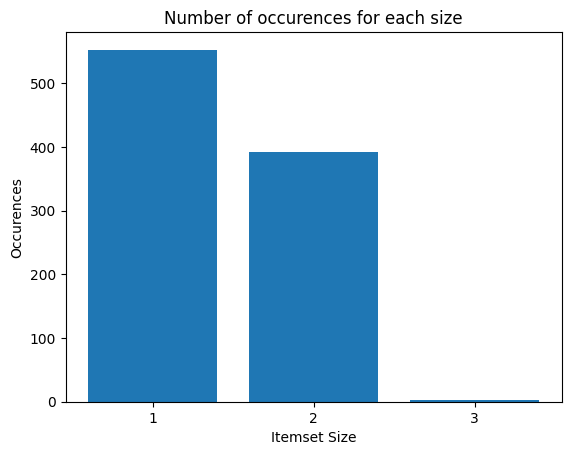

In [ ]:
import matplotlib.pyplot as plt

pair_lengths = list(pair_counts.keys()) # extract the keys (pair lengths) from the pair_counts dictionary and convert them into a list
pair_frequency = list(pair_counts.values()) # extract the values (occurrences counts) from the pair_counts dictionary and convert them into a list

# Plot
plt.bar(pair_lengths, pair_frequency)
plt.xlabel('Itemset Size')
plt.ylabel('Occurences')
plt.title('Number of occurences for each size')
plt.xticks(pair_lengths)
plt.show()

# Computation time with increasing threshold

In [ ]:
#SAMPLING for ratio threshold over time
#analyze the time needed by the algorithm by varying the minimum support

import time

sample = rdd.sample(False, 0.25, seed = 23)
#create a list which will contain the elapsed time for each threshold
elapsed = []
#create a list which will contain the frequent items for each threshold
frequent = []
#count the number of baskets to compute the minimum support
count = sample.count()
#will contain the support size in the format t*0,01
threshold_ap = []
for t in range(3,9):
  #save the start time
  start = time.time()
  #compute the support size
  threshold_perc = t*0.01
  threshold_ap.append(threshold_perc)
  #perform apriori on the sample using as support threshold_perc*count
  frequent.append(list(apriori(sample, threshold_perc*count).collect()))
  #save the end time
  end = time.time()
  #calculate the elapsed time
  interval = end - start
  elapsed.append(interval)

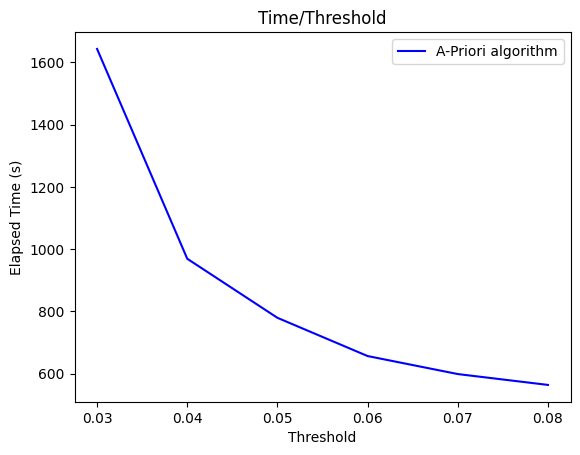

In [ ]:
#apriori plot for threshold size between 0.03 and 0.08 on 25% size sample
import matplotlib.pyplot as plt

time_threshold_ratio = pd.DataFrame() # Create an empty df
time_threshold_ratio['Elapsed_time'] = elapsed # add column 'elapsed time'
time_threshold_ratio['Threshold'] = threshold_ap # add column 'threshold'
plt.plot(time_threshold_ratio['Threshold'], time_threshold_ratio['Elapsed_time'],
         label = 'A-Priori algorithm', color = 'blue')
plt.xlabel('Threshold')
plt.ylabel('Elapsed Time (s)')
plt.legend()
plt.title('Time/Threshold')
plt.show()